###  Content Analysis News Media Outlets- Inmigration Posts

### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_News_Media_Outlets_immigration_random.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(4637, 38)

In [5]:
posts['URL']

0       https://www.facebook.com/ElMundoUSA/posts/3742...
1       https://www.facebook.com/NoticiasUnivisionKans...
2       https://www.facebook.com/telemundodenver/posts...
3       https://www.facebook.com/vida.newspaper/posts/...
4       https://www.facebook.com/Univision19/posts/397...
                              ...                        
4632    https://www.facebook.com/Telemundo48/posts/377...
4633    https://www.facebook.com/HispanicNetworkMagazi...
4634    https://www.facebook.com/TelemundoNI/posts/422...
4635    https://www.facebook.com/Telemundo49/posts/386...
4636    https://www.facebook.com/sjdailystar/posts/333...
Name: URL, Length: 4637, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-10-01 17:00:24 EDT
1    2020-10-25 23:30:03 EDT
2    2020-10-23 20:31:26 EDT
3    2020-11-02 17:22:27 EST
4    2020-10-04 19:41:28 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-10-01 17:00:24-04:00
1      2020-10-25 23:30:03-04:00
2      2020-10-23 20:31:26-04:00
3      2020-11-02 17:22:27-05:00
4      2020-10-04 19:41:28-04:00
                  ...           
4632   2020-10-26 11:57:10-04:00
4633   2020-10-16 13:06:11-04:00
4634   2020-08-19 03:37:01-04:00
4635   2020-10-26 22:51:58-04:00
4636   2020-10-15 12:30:17-04:00
Name: converted_date, Length: 4637, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date'] = posts['converted_date'].dt.date
posts['converted_date'] 

0       2020-10-01
1       2020-10-25
2       2020-10-23
3       2020-11-02
4       2020-10-04
           ...    
4632    2020-10-26
4633    2020-10-16
4634    2020-08-19
4635    2020-10-26
4636    2020-10-15
Name: converted_date, Length: 4637, dtype: object

In [11]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date 

,converted_date,count
0,2020-08-18,60
1,2020-08-19,77
2,2020-08-20,65
3,2020-08-21,86
4,2020-08-22,28
5,2020-08-23,36
6,2020-08-24,56
7,2020-08-25,74
8,2020-08-26,100
9,2020-08-27,68


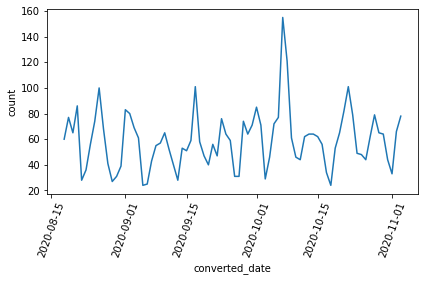

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score,clean_url,State,Facebook,MessageDescr,MessageOnly,converted_date
10,77981,Lobo 97.7,Lobo97.7FM,177791572266673,162825.0,2020-08-30 12:30:10 EDT,Link,0,0,0,...,NaN,0,0,-38,lobo97.7fm,Nebraska,https://www.facebook.com/Lobo97.7FM/,Las autoridades dicen que un conductor que iba...,Las autoridades dicen que un conductor que iba...,2020-08-30


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [17]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Alabama,15
1,Alaska,6
2,Arizona,164
3,Arkansas,3
4,California,668
5,Colorado,120
6,Connecticut,85
7,Delaware,12
8,District of Columbia,130
9,Florida,339


In [18]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Alabama,15
1,Alaska,6
2,Arizona,164
3,Arkansas,3
4,California,668
5,Colorado,120
6,Connecticut,85
7,Delaware,12
8,District of Columbia,130
9,Florida,339


## 3. Which groups are publishing the majority of the content

In [19]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
NotiCel,325
CNN en Espaol,141
La Noticia,105
NoticiasYa Colorado,98
Univision,81
Telemundo Arizona,77
NoticiasYa Costa Central,68
NoticiasYa San Diego,65
El Nuevo Da,63


In [20]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (504, 39)
republicans (924, 39)
general politics (53, 39)
none (3483,)


444

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [21]:
posts_democrats['MessageDescr'][3:6]

57     DECISIÓN 2020: TRUMP Y BIDEN DEBATEN SOBRE LA ...
95     "Nevada y Estados Unidos necesitan cuatro años...
104    "Este comportamiento que está a la luz ahora q...
Name: MessageDescr, dtype: object

In [22]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly', 'converted_date'],
      dtype='object')

In [23]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [24]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [25]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [26]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [27]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
22,Alabama,4,6,1,8
41,Alaska,0,0,0,6
8,Arizona,23,43,0,109
42,Arkansas,0,0,0,3
0,California,67,153,12,485
10,Colorado,18,33,3,77
16,Connecticut,8,18,0,62
31,Delaware,1,3,0,9
7,District of Columbia,25,33,0,86
2,Florida,48,86,1,239


In [28]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

Series([], Name: MessageDescr, dtype: object)

## FB Groups Political Posts

In [29]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,California,232
1,Texas,171
2,Florida,135
3,Georgia,109
4,Puerto Rico,106
5,New York,83
6,North Carolina,70
7,Arizona,66
8,District of Columbia,58
9,Colorado,54


## Tokenize words and Clean-up text

In [30]:
content = posts.copy()
content['MessageDescr'].head()

0    Agentes del Servicio de Control de Inmigración y Aduanas (#ICE) intentaron detener este jueves a #PaulineBinam, la madre #indocumentada que denunció haber sido esterilizada mientras estaba bajo la custodia de las autoridades federales en #Georgia, y que fue liberada por razones humanitarias después de casi haber sido deportada, confirmó su abogada. https://www.elmundous.com/2020/10/01/el-ice-i...
1    Admitiendo que no pueden controlar la pandemia que dejaron crecer, la Casa Blanca ahora dice que lo importante es que haya vacunas y tratamientos para que la gente no muera. La administración Trump se ha caracterizado por desestimar las medidas para reducir la propagación del coronavirus “No vamos a controlar la pandemia”, admite la Casa Blanca https://noticiasya.com/2020/10/25/no-vamos-a-cont...
2    El amor de una madre lo puede todo. Véalo aquí. https://trib.al/ao3uUSS:=:https://www.telemundodenver.com/noticias/local/una-mujer-que-lo-perdio-todo-sale-adelante-en-medio-de-la-pandem

In [31]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(4637,)

In [32]:
# Convert to list
data = content.cleanMessage.tolist()

In [33]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['agentes', 'del', 'servicio', 'de', 'control', 'de', 'inmigracion', 'aduanas', 'ice', 'intentaron', 'detener', 'este', 'jueves', 'paulinebinam', 'la', 'madre', 'indocumentada', 'que', 'denuncio', 'haber', 'sido', 'esterilizada', 'mientras', 'estaba', 'bajo', 'la', 'custodia', 'de', 'las', 'autoridades', 'federales', 'en', 'georgia', 'que', 'fue', 'liberada', 'por', 'razones', 'humanitarias', 'despues', 'de', 'casi', 'haber', 'sido', 'deportada', 'confirmo', 'su', 'abogada'], ['admitiendo', 'que', 'no', 'pueden', 'controlar', 'la', 'pandemia', 'que', 'dejaron', 'crecer', 'la', 'casa', 'blanca', 'ahora', 'dice', 'que', 'lo', 'importante', 'es', 'que', 'haya', 'vacunas', 'tratamientos', 'para', 'que', 'la', 'gente', 'no', 'muera', 'la', 'administracion', 'trump', 'se', 'ha', 'caracterizado', 'por', 'desestimar', 'las', 'medidas', 'para', 'reducir', 'la', 'propagacion', 'del', 'coronavirus', 'no', 'vamos', 'controlar', 'la', 'pandemia', 'admite', 'la', 'casa', 'blanca']]


#### Creating Bigram and Trigram Models

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['agentes', 'del', 'servicio', 'de', 'control', 'de', 'inmigracion_aduanas_ice', 'intentaron', 'detener', 'este', 'jueves', 'paulinebinam', 'la', 'madre', 'indocumentada', 'que', 'denuncio', 'haber_sido', 'esterilizada', 'mientras', 'estaba', 'bajo', 'la', 'custodia', 'de', 'las', 'autoridades', 'federales', 'en', 'georgia', 'que', 'fue', 'liberada', 'por', 'razones', 'humanitarias', 'despues', 'de', 'casi', 'haber_sido', 'deportada', 'confirmo', 'su', 'abogada']


## Remove Stopwords, Make Bigrams and Lemmatize

In [36]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [37]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [39]:
print(data_words_nostops[1:2])

[['admitiendo', 'pueden', 'controlar', 'pandemia', 'dejaron', 'crecer', 'casa', 'blanca', 'ahora', 'dice', 'importante', 'vacunas', 'tratamientos', 'gente', 'muera', 'administracion', 'trump', 'caracterizado', 'desestimar', 'medidas', 'reducir', 'propagacion', 'coronavirus', 'vamos', 'controlar', 'pandemia', 'admite', 'casa', 'blanca']]


## Bag of Words

In [40]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [41]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [42]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [43]:
final_dict.most_common(1000)

[('decir', 1485),
 ('trump', 673),
 ('covid / coronavirus', 550),
 ('ano', 522),
 ('personar', 491),
 ('nuevo', 410),
 ('president / presidente', 390),
 ('hacer', 375),
 ('debatir', 277),
 ('poder', 272),
 ('policia', 266),
 ('ahora', 263),
 ('hoy', 260),
 ('mujer', 255),
 ('elección', 248),
 ('frontero', 242),
 ('caso', 234),
 ('partir', 228),
 ('votar', 226),
 ('mexico', 224),
 ('http_notiya', 217),
 ('inmigrante', 216),
 ('licenciar', 212),
 ('pandemia', 207),
 ('autoridad', 199),
 ('pasar', 197),
 ('familia', 194),
 ('solo', 192),
 ('vicepresidente', 192),
 ('hijo', 190),
 ('trabajar', 190),
 ('hombre', 187),
 ('candidato', 180),
 ('contar', 179),
 ('anunciar', 177),
 ('publicar', 176),
 ('detalle', 175),
 ('dar', 174),
 ('muerte', 173),
 ('ayudar', 171),
 ('servicio', 170),
 ('tambien', 165),
 ('donald_trump', 165),
 ('casar', 165),
 ('llegar', 164),
 ('info', 161),
 ('federal', 159),
 ('politica', 158),
 ('semana', 158),
 ('unir', 158),
 ('indocumentado', 156),
 ('agente', 153),


In [44]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [47]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [48]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [49]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
decir,2.411181
trump,3.312988
coronavirus,3.572742
personar,3.575570
ano,3.586967
nuevo,3.751679
hacer,3.755063
presidente,3.765285
ahora,3.986717
poder,4.039361


In [50]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [51]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [52]:
df

,tfidf
abogar,0.170216
agente,0.161237
autoridad,0.147230
casi,0.180133
confirmar,0.203334
denunciar,0.178445
deportar,0.206989
despues,0.154699
detener,0.177365
esterilizar,0.262172


In [53]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,"su vida parecía una película de acción y todos participaban en ella sin imaginarlo, hasta que las mentiras fueron descubiertas por verdaderos agentes federales. se ostentó como un agente federal frente a su propia familia, amigos, compañeros de trabajo y hasta con la policía fingió ser un agente de ice y hasta participó en un operativo federal",6
1,agentes fronterizos rescatan a una madre que entró en labores de parto en campo abierto y en plena noche.,5
2,"los agentes de la patrulla fronteriza indentificaron a porfirio martínez santos cuando buscaba ingresar de nuevo a estados unidos. agentes de la patrulla fronteriza identificaron a un delincuente sexual que intentó volver a entrar ilegalmente a los estados unidos. ayer por la tarde, agentes que trabajaban cerca de peñitas, arr… arrestan a inmigrante indocumentado convicto por contacto sexual a...",3
3,autoridades identifican al hombre baleado a muerte por un agente al intentarcruzar la frontera por san ysidro. las autoridades identifican al ciudadano mexicano que murió a manos de la patrulla fronteriza durante un altercado cerca del centro comercial de san ysidro. la víctima fue identificada como david á… identifican hombre asesinado por patrulla fronteriza en san ysidro,2
4,"un par de detenciones arbitrarias por parte de ice en massachusetts han causado indignación, incluyendo la de un hombre de 29 años que estaba haciendo ejercicio. bena apreala estaba haciendo ejercicio cuando agentes de ice se le acercaron sin identificarse video: ice detiene a corredor negro y causa indignación http://notiya.info/tmdtv",2
5,"tener números de teléfono y documentos importantes a la mano, así como asegurarse de designar a alguien que cuide de sus hijos, son algunas de las recomendaciones que hacen los abogados de inmigración. tener números de teléfono y documentos importantes a la mano, así como asegurarse de designar a alguien que cuide de sus hijos, son algunas de las recomendaciones que hacen los abogados de inmig...",2
6,"el inmigrante que vive en arizona pidió ayuda sin saber la pesadilla que desataría. un residente de phoenix cuenta a univision que después de pedir ayuda a un oficial de dps cuando su auto se averió a la orilla de una carretera. sin embargo, cuando llegaron los agentes le cuestionaron sobre su estatus migratorio. se le descompuso su auto, solicitó ayuda y le llegaron los agentes de ice",2
7,cientos de agentes de la guardia nacional impedirán el paso de la caravana de inmigrantes que salió de honduras a eeuu.,2
8,"un operativo de múltiples agencias de ley llevó al arresto de varios ciudadanos de méxico, el salvador, honduras, ecuador y guatemala. los agentes de la patrulla fronteriza, en conjunto con múltiples agencias de la ley, descubrieron cinco escondites y 35 inmigrantes indocumentados. el lunes, los agentes recibieron información de u… descubren 5 escondites de tráfico humano y arrestan a 35 indoc...",2
9,"según una reciente publicación del washington post. la agencia de inmigracion ""ice"" se prepara para llevar a cabo una serie de redadas de inmigrantes en ciudades santuario como denver. nuestro compañero jesús carrasquel nos cuenta si esto es legal y que debe hacer si agentes de ice tocan a su puerta. presuntos operativos de ice en ciudades santuario",2


### Repeated messages

In [54]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [58]:
results.sort_values(by='Total Interactions',ascending=False).head(20)

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
"¡Y QUIEREN TENER MÁS🤱! Conoce la familia Hernandez, una familia de 17 (por ahora).👨‍👩‍👧‍👦 Una madre latina con 15 hijos ha revelado que está embarazada de su 16to hijo, solo tres meses después de dar a luz, y dice que quiere ... Madre latina está embarazada de su 16to hijo, solo tres meses después de dar a luz https://www.lanoticia.com/madre-latina-esta-embarazada-de-su-16to-hijo/?utm_campaign=lanoticia&utm_medium=page&utm_source=facebook.com",https://www.lanoticia.com/madre-latina-esta-embarazada-de-su-16to-hijo/?utm_campaign=lanoticia&utm_medium=page&utm_source=facebook.com,1,10847,7932,8577,842,21769,1078,845,5771,152,57813
"“Quiero a mis hijos, quiero volver a tenerlos”, suplica Erick que fue deportado cuando su novia estaba embarazada. Mira aquí la historia completa https://trib.al/dOMWHa2:=:https://www.telemundoarizona.com/noticias/local/padre-salvadoreno-regresa-a-arizona-y-encuentra-que-sus-bebes-fueron-adoptados/2097566/ “Quiero volver a tenerlos”, dice entre lágrimas Erick Castillón, quien dice ser padre biológico de los gemelos de los que ahora no sabe nada. Salvadoreño regresa a Arizona tras su deportación y dice que sus bebés fueron adoptados https://trib.al/dOMWHa2",https://trib.al/dOMWHa2,1,3793,249,1347,41,1313,24,7871,302,18,14958
"🔴 Alcalde pide la restricción para ingresos de norteamericanos a #México para actividades no esenciales ⤵️ El Ayuntamiento formalizará la petición a la SRE para que negocie con el gobierno norteamericano, dijo el alcalde Armando Cabada Pide Cabada CERRAR FRONTERA a estadounidenses https://diario.mx/juarez/solicitara-municipio-impedir-el-paso-de-estadounidenses-a-mexico-20201019-1721071.html",https://diario.mx/juarez/solicitara-municipio-impedir-el-paso-de-estadounidenses-a-mexico-20201019-1721071.html,1,5864,1343,970,1140,232,857,22,37,33,10498
"La fortuna de Elon Musk sigue creciendo, ahora es la tercera persona más rica del mundo https://cnn.it/3jDnjgu:=:https://cnnespanol.cnn.com/video/elom-musk-rico-mark-zuckerberg-fortuna-lista-multimillonarios-mundial-bloomberg-lklv-portafolio/ La fortuna del fundador de Tesla sigue creciendo. Según el Índice de multimillonarios de Bloomberg, Elon Musk es ahora es la tercera persona más rica del mundo y dejó en cuarto puesto al presidemte… Elon Musk ahora es más rico que Mark Zuckerberg https://cnn.it/3jDnjgu",https://cnn.it/3jDnjgu,1,6784,741,680,743,1067,144,20,53,46,10278
"Trump ha tenido fiebre desde esta mañana, dice una persona familiarizada con el asunto. La persona dijo que la fiebre sigue siendo consistente con la descripción anterior de la Casa Blanca de «síntomas leves». https://cnn.it/3cRU33f:=:https://cnnespanol.cnn.com/2020/10/02/minuto-a-minuto-la-salud-de-donald-y-melania-trump/ Timeline Photos https://www.facebook.com/CNNee/photos/a.132943482643/10157781433092644/?type=3",https://www.facebook.com/CNNee/photos/a.132943482643/10157781433092644/?type=3,1,3854,1528,672,81,902,1044,454,16,37,8588
Dicen que el rival aún está tratando de entender cómo lo hizo. 😵 🏓 (via ittfworld / IG) ¿Cómo?. https://www.facebook.com/ESPNDeportes/videos/354612569177786/,https://www.facebook.com/ESPNDeportes/videos/354612569177786/,1,4376,647,1286,604,1016,379,2,2,23,8335
"¡Muchas felicidades a ambas y a todo el equipo que formó parte de los proyectos! https://bit.ly/3goc89p:=:https://www.wapa.tv/noticias/entretenimiento/reporteras-de-noticentro-son-galardonadas-por-la-asppro_20131122485014.html Los editores Ruddy Matta y Richard París, como los camarógrafos Carlos Moctezuma y Gadiel Lasalle, también formaron parte de los proyectos. Reporteras de NotiCentro son galardonadas por la Asppro https://bit.ly/3goc89p",https://bit.ly/3goc89p,1,5302,1132,219,957,2,3,0,1,50,7666
"#Viral | Compartió su molestia en redes sociales; vendedor dice que sí envió las computadoras 😕 Indignado reclamó a la plataforma y al vendedor, pero concluyeron que realmente 

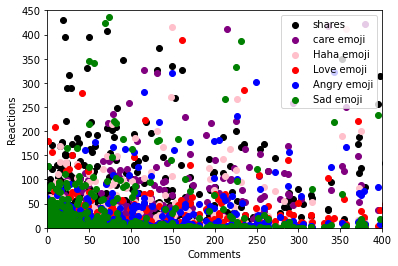

In [59]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [60]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model



[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [61]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.075*"ayudar" + 0.073*"ciudad" + 0.070*"virus" + 0.052*"redar" + '
  '0.045*"obtener" + 0.041*"martes" + 0.039*"control" + 0.036*"democrata" + '
  '0.035*"nacional" + 0.028*"mejor"'),
 (1,
  '0.096*"hacer" + 0.048*"dar" + 0.045*"solo" + 0.044*"indocumentado" + '
  '0.037*"ser" + 0.034*"estadounidense" + 0.032*"politica" + 0.028*"campana" + '
  '0.027*"visitar" + 0.022*"destinar"'),
 (2,
  '0.139*"puerto_rico" + 0.100*"donald_trump" + 0.096*"ninos" + 0.075*"padre" '
  '+ 0.053*"bien" + 0.049*"viernes" + 0.042*"representante" + 0.040*"indicar" '
  '+ 0.036*"poner" + 0.024*"separar"'),
 (3,
  '0.138*"partir" + 0.137*"licenciar" + 0.114*"candidato" + 0.061*"personal" + '
  '0.038*"frente" + 0.035*"mostrar" + 0.028*"ademar" + 0.025*"candidatura" + '
  '0.025*"alcalde" + 0.020*"ocurrir"'),
 (4,
  '0.072*"hijo" + 0.069*"vida" + 0.061*"vestir" + 0.053*"casar" + '
  '0.048*"llevar" + 0.047*"historia" + 0.044*"explicar" + 0.042*"seguir" + '
  '0.041*"permitir" + 0.039*"experto"'),
 (5,


In [63]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -18.115199375668848

Coherence Score:  0.3860787880425846


In [64]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.365213 -0.198881       1        1  13.345200
1      0.117017  0.289480       2        1   9.274388
16     0.095326  0.159491       3        1   8.551225
8      0.094615  0.151480       4        1   8.094690
17     0.139422 -0.090024       5        1   7.857185
4     -0.000251  0.015236       6        1   5.270004
6     -0.016201 -0.007364       7        1   5.060283
11    -0.015099 -0.006336       8        1   4.806853
15    -0.039504 -0.018307       9        1   4.698068
19    -0.037471 -0.017784      10        1   4.414760
10    -0.061937 -0.026701      11        1   3.826294
13    -0.043002 -0.019791      12        1   3.744021
0     -0.052460 -0.023611      13        1   3.577380
3     -0.069823 -0.028716      14        1   3.316245
12    -0.061909 -0.026535      15        1   3.307239
7     -0.068763 -0.028445      16        1   3.214792
14    -0.070131 -0.028844      17        1   3.101935
2     -0.065563 -0.027411      18        1   2.918697
9     -0.100679 -0.033903      19        1   1.255205
18    -0.108801 -0.033033      20        1   0.365544, topic_info=                            Term         Freq        Total Category  logprob  \
29                         decir  2689.000000  2689.000000  Default  30.0000   
40                         trump  1375.000000  1375.000000  Default  29.0000   
405                     personar  1026.000000  1026.000000  Default  28.0000   
68                           ano   791.000000   791.000000  Default  27.0000   
27                   coronavirus   979.000000   979.000000  Default  26.0000   
48                         nuevo   607.000000   607.000000  Default  25.0000   
72                         hacer   728.000000   728.000000  Default  24.0000   
60                           hoy   464.000000   464.000000  Default  23.0000   
96                      elección   387.000000   387.000000  Default  22.0000   
49                    presidente   664.000000   664.000000  Default  21.0000   
189                       mexico   397.000000   397.000000  Default  20.0000   
487                       partir   374.000000   374.000000  Default  19.0000   
199                   inmigrante   418.000000   418.000000  Default  18.0000   
534                    licenciar   371.000000   371.000000  Default  17.0000   
173                      debatir   382.000000   382.000000  Default  16.0000   
184                     frontero   358.000000   358.000000  Default  15.0000   
426                  puerto_rico   331.000000   331.000000  Default  14.0000   
197                      familia   340.000000   340.000000  Default  13.0000   
530                    candidato   310.000000   310.000000  Default  12.0000   
174                  http_notiya   353.000000   353.000000  Default  11.0000   
563                         usar   333.000000   333.000000  Default  10.0000   
348               vicepresidente   307.000000   307.000000  Default   9.0000   
153                      policia   398.000000   398.000000  Default   8.0000   
69                      anunciar   318.000000   318.000000  Default   7.0000   
66                         salud   381.000000   381.000000  Default   6.0000   
292                        pasar   293.000000   293.000000  Default   5.0000   
151                        mujer   309.000000   309.000000  Default   4.0000   
37                         poder   610.000000   610.000000  Default   3.0000   
553                        ee_uu   304.000000   304.000000  Default   2.0000   
23                         ahora   471.000000   471.000000  Default   1.0000   
29                         decir  2688.086426  2689.620850   Topic1  -1.3972   
40                         trump  1374.236694  1375.770996   Topic1  -2.0682   
27                   coronavirus   978.302246   979.836487   Topic1  -2.4080   
49                    presidente   663.256836   6

## Building LDA Mallet Model

In [65]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [66]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('esperar', 0.03754266211604096),
   ('llegar', 0.033079548437910215),
   ('podria', 0.03255447624048307),
   ('hora', 0.028353898661065895),
   ('ahora', 0.027303754266211604),
   ('noche', 0.024940929377789446),
   ('vez', 0.023890784982935155),
   ('miercoles', 0.021527960094512997),
   ('jueves', 0.021002887897085848),
   ('cercar', 0.019952743502231557)]),
 (3,
  [('publicar', 0.033289241622574954),
   ('pagar', 0.025793650793650792),
   ('dolar', 0.025573192239858905),
   ('millón', 0.025352733686067018),
   ('funcionario', 0.01763668430335097),
   ('representante', 0.01675485008818342),
   ('trabajador', 0.016534391534391533),
   ('incluir', 0.016313932980599646),
   ('fiscal', 0.015873015873015872),
   ('emplear', 0.015652557319223985)]),
 (11,
  [('familia', 0.05244660719113274),
   ('usar', 0.03919978372533117),
   ('asegurar', 0.03190051365233847),
   ('solo', 0.031630170316301706),
   ('manana', 0.023249526899161935),
   ('gente', 0.0227088402270884),
   ('comunida

## Finding the optimal number of topics for LDA

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [69]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

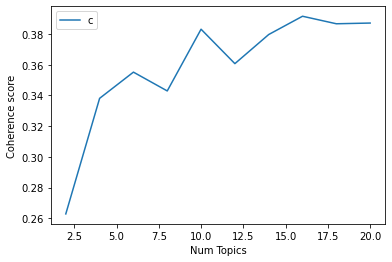

In [70]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2628
Num Topics = 4  has Coherence Value of 0.3381
Num Topics = 6  has Coherence Value of 0.3552
Num Topics = 8  has Coherence Value of 0.343
Num Topics = 10  has Coherence Value of 0.3832
Num Topics = 12  has Coherence Value of 0.3608
Num Topics = 14  has Coherence Value of 0.3797
Num Topics = 16  has Coherence Value of 0.3917
Num Topics = 18  has Coherence Value of 0.3868
Num Topics = 20  has Coherence Value of 0.3872


In [72]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"hoy" + 0.050*"votar" + 0.045*"elección" + 0.036*"donald_trump" + '
  '0.028*"politica" + 0.025*"destinar" + 0.022*"vicepresidencia" + '
  '0.021*"visitar" + 0.018*"noviembre" + 0.016*"registrar"'),
 (1,
  '0.040*"inmigrante" + 0.032*"indocumentado" + 0.031*"agente" + '
  '0.030*"federal" + 0.027*"arrestar" + 0.025*"oficial" + 0.018*"ser" + '
  '0.018*"personar" + 0.016*"denunciar" + 0.016*"detenido"'),
 (2,
  '0.098*"decir" + 0.033*"ahora" + 0.027*"post" + 0.025*"menos" + '
  '0.024*"abogar" + 0.023*"explicar" + 0.023*"personar" + 0.020*"poner" + '
  '0.020*"http" + 0.017*"legal"'),
 (3,
  '0.026*"condado" + 0.023*"gobernador" + 0.020*"ano" + 0.019*"gran" + '
  '0.016*"mayor" + 0.016*"puerto_rico" + 0.016*"grupo" + 0.015*"nuevo" + '
  '0.014*"sector" + 0.013*"partir"'),
 (4,
  '0.039*"licenciar" + 0.030*"servicio" + 0.027*"personar" + 0.021*"ley" + '
  '0.018*"cerrar" + 0.017*"personal" + 0.016*"deber" + 0.016*"poder" + '
  '0.015*"realizar" + 0.014*"manera"'),
 (5,
  '0

## Finding the dominant topic in each sentence

In [73]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2209,"inmigrante, indocumentado, agente, federal, arrestar, oficial, ser, personar, denunciar, detenido","Agentes del Servicio de Control de Inmigración y Aduanas (#ICE) intentaron detener este jueves a #PaulineBinam, la madre #indocumentada que denunció haber sido esterilizada mientras estaba bajo la custodia de las autoridades federales en #Georgia, y que fue liberada por razones humanitarias después de casi haber sido deportada, confirmó su abogada."
1,1,15.0,0.1023,"nuevo, pasar, contar, detalle, ciudad, buscar, medir, pedir, septiembre, mesar","Admitiendo que no pueden controlar la pandemia que dejaron crecer, la Casa Blanca ahora dice que lo importante es que haya vacunas y tratamientos para que la gente no muera. La administración Trump se ha caracterizado por desestimar las medidas para reducir la propagación del coronavirus “No vamos a controlar la pandemia”, admite la Casa Blanca"
2,2,0.0,0.0625,"hoy, votar, elección, donald_trump, politica, destinar, vicepresidencia, visitar, noviembre, registrar",El amor de una madre lo puede todo. Véalo aquí.
3,3,12.0,0.0765,"familia, programar, ninos, trabajar, poder, pandemia, virtual, escuela, estudiante, trabajador","A person has been arrested after leading deputies on a high speed pursuit which exceeded 120 MPH through the Cities of Camarillo and Thousand Oaks. In the early morning hours of October 29, 2020, a deputy from the Camarillo Police Department attempted to make a traffic enforcement stop on a vehicle registered to Noe Marquez, a 22 years old resident of Simi Valley. [ 329 more words ]"
4,4,8.0,0.0813,"debatir, http_notiya, vicepresidente, info, candidato, hispano, temer, ﻿1, vivir, latino",- Este lunes el EDD empezará a recibir nuevas solicitudes de desempleo. - El presidente sale brevemente del hospital para saludar a sus simpatizantes. Con esto y más los esperamos en vivo a las 6pm con Maricela De La Cruz Breve Informativo
5,5,14.0,0.2949,"coronavirus, caso, muerte, personar, experto, casar, pandemia, salud, reportar, posible",El informe agrega una muerte y 206 casos probables. El informe agrega una muerte y 206 casos probables El informe del Departamento de Salud reportó cuatro muertes por COVID-19; al tiempo que se registraron 230 casos confirmados y 206 casos probables ad... Informe de Salud reporta hoy tres muertes y 230 casos confirmados
6,6,9.0,0.1368,"policia, ano, hijo, hombre, mujer, autoridad, decir, encontrar, despues, morir","OMG! A principios del año el Niño Prodigio dijo esto sobre #Chiquis y #Lorenzo. 😱🤭 A principios de año, el reconocido astrólogo declaró que en sus cartas veía a la hija de Jenni Rivera con un hombre diferente y tras el reciente anuncio de su separación, parece que esto se podría hacer realidad. “Yo siempre he visto un hombre más mayor en la vida de Chiquis"": lo que el Niño Prodigio predijo par..."
7,7,0.0,0.1254,"hoy, votar, elección, donald_trump, politica, destinar, vicepresidencia, visitar, noviembre, registrar","Oso siberiano y tigre predicen quién ganará en las #Elecciones2020 🐻🐯 Se trata de un oso siberiano y un tigre dentro de un zoológico, a los cuales se les ofreció sandías con las imágenes de ambos candidatos para ver a cuál elegían. 🍉 Buyan, es un oso pardo macho que habita en un zoológico de Siberia y él no dudó en elegir a Joe Biden 🔵 como el ganador, mientras que Khan, un tigre de bengala de..."
8,8,15.0,0.3540,"nuevo, pasar, contar, detalle, ciudad, buscar, medir, pedir, septiembre, mesar","Tal y como lo reportamos hace unos días la foto de dos menores estudiando afuera del restaurante Taco Bell ha causado controversia. Refleja la cruda realidad, así como la ausencia de un sistema que resuelve las necesidades de internet de los estudiantes en la costa central. El distrito escolar de primarias de Salinas ha tomado cartas en el asunto y otorgó puntos de Internet a la Familia de las..."
9,9,1.0,0.0751,"inmigrante, indocumentado, agente, federal, ar

## Find the most representative document for each topic


In [74]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3684,"hoy, votar, elección, donald_trump, politica, destinar, vicepresidencia, visitar, noviembre, registrar","🗳️ ¡Estamos a solo 27 días de las elecciones! En Arizona, hoy comienza el voto por correo y voto temprano.Y si aún no te registraste en Missouri, recuerda que es el último día. ¿Listos para el debate vicepresidencial? 🇺🇸 Visita univision.com/votaconmigo:=:http://univision.com/votaconmigo e infórmate. #Destino2020 🗳️ ¡Estamos a solo 27 días de las elecciones! En Arizona, hoy comienza el voto po..."
1,1.0,0.3801,"inmigrante, indocumentado, agente, federal, arrestar, oficial, ser, personar, denunciar, detenido","Un oficial del Maricopa County Sheriffs Office es acusado de conducta sexual ilegal Inicio General Local Un oficial del Sheriff de Maricopa acusado de conducta sexual ilegal GeneralLocal Un oficial del Sheriff de Maricopa acusado de conducta sexual ilegal Por Redacción - October 5, 2020 Facebook Twitter WhatsApp Print Un oficial de la Oficina del Sheriff del condado de Maricopa fu... Un oficia..."
2,2.0,0.5024,"decir, ahora, post, menos, abogar, explicar, personar, poner, http, legal","""Lo que yo pasé ahí como periodista, lo enfrentan miles de personas todos los días en las calles"", nos dice Ilia Calderon. Y nos recuerda que para una sociedad justa y unida, con paz e igualdad: necesitamos alzar nuestras voces, como ciudadanas, como inmigrantes, como mujeres. Menos ""calladita te ves más bonita"" y más participación, es lo que necesitamos. Por eso, este 2020 #JuntasVotamos. 💪 R..."
3,3.0,0.5489,"condado, gobernador, ano, gran, mayor, puerto_rico, grupo, nuevo, sector, partir","[NEGOCIOS] Premian el emprendimiento boricua en la segunda edición de los Emprendedores del año de eBay Por segundo año consecutivo, eBay, el marketplace más grande del mundo, celebra y premia el emprendimiento al reconocer a los mejores vendedores del año que han sabido aprovechar las bondades del comercio electrónico para construir negocios exitosos, de gran impacto y con alcance mundial. En..."
4,4.0,0.5876,"licenciar, servicio, personar, ley, cerrar, personal, deber, poder, realizar, manera","[LOCALES] Disponible nuevo sistema de citas en línea en el Departamento de Hacienda El secretario del Departamento de Hacienda, Francisco Parés Alicea, anunció la disponibilidad de un nuevo sistema en línea para que los contribuyentes puedan hacer citas y realizar sus gestiones en una fecha determinada, sin filas, ni aglomeración de público. “Con mucha satisfacción les informo que ya tenemos d..."
5,5.0,0.6407,"millón, publicar, pagar, dolar, partir, ano, funcionario, representante, fiscal, emplear","[LOCALES] Gobernadora indica que están listos los Estados Financieros Auditados del año 2017 La gobernadora Wanda Vázquez Garced y el secretario del Departamento de Hacienda, Francisco Parés Alicea, informaron hoy la emisión de los Estados Financieros Auditados del Gobierno de Puerto Rico, para el año fiscal terminado el 30 de junio de 2017. “El informe de los auditores independientes de la fi..."
6,6.0,0.3437,"trump, presidente, decir, campana, apoyar, martes, estadounidense, presidencial, ganar, democrata","La candidata demócrata a la vicepresidencia, Kamala Harris, dijo que la interferencia extranjera, los cuestionamientos del presidente Donald Trump sobre las elecciones y la supresión de votantes podrían costarles a ella y a Joe Biden la Casa Blanca en noviembre. “Soy realista sobre esto. Joe también es realista sobre esto”, dijo la senadora de California durante una entrevista con el programa ..."
7,7.0,0.3158,"decir, coronavirus, semana, momento, anunciar, noticiar, armar, viernes, virus, probar","GOBERNADORA DE ALABAMA EXTENDIÓ LA ORDEN ‘SAFER AT HOME’ Y EL USO DE CUBREBOCAS HASTA EL 2 OCTUBRE * La gobernadora Kay Ivey extendió hoy la orden de seguridad en el hogar del estado, que incluye el mandato de máscaras, hasta el 2 de octubre. * La orden expiraría el próximo lunes. La gobernadora anunc

In [75]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [76]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"inmigrante, indocumentado, agente, federal, arrestar, oficial, ser, personar, denunciar, detenido",437.0,0.0942
1.0,15.0,"nuevo, pasar, contar, detalle, ciudad, buscar, medir, pedir, septiembre, mesar",347.0,0.0748
2.0,0.0,"hoy, votar, elección, donald_trump, politica, destinar, vicepresidencia, visitar, noviembre, registrar",241.0,0.0520
3.0,12.0,"familia, programar, ninos, trabajar, poder, pandemia, virtual, escuela, estudiante, trabajador",223.0,0.0481
4.0,8.0,"debatir, http_notiya, vicepresidente, info, candidato, hispano, temer, ﻿1, vivir, latino",228.0,0.0492
5.0,14.0,"coronavirus, caso, muerte, personar, experto, casar, pandemia, salud, reportar, posible",201.0,0.0433
6.0,9.0,"policia, ano, hijo, hombre, mujer, autoridad, decir, encontrar, despues, morir",362.0,0.0781
7.0,0.0,"hoy, votar, elección, donald_trump, politica, destinar, vicepresidencia, visitar, noviembre, registrar",234.0,0.0505
8.0,15.0,"nuevo, pasar, contar, detalle, ciudad, buscar, medir, pedir, septiembre, mesar",344.0,0.0742
9.0,1.0,"inmigrante, indocumentado, agente, federal, arrestar, oficial, ser, personar, denunciar, detenido",358.0,0.0772
